In [5]:
#!pip install opencv-python

In [6]:
#!pip install matplotlib

In [7]:
import os
import shutil
from sqlalchemy import create_engine, event, Table
from sqlalchemy.orm import sessionmaker

import shapely.wkb
import numpy as np
import cv2

from sqlalchemy import inspect


from quickannotator.db import db_session, Project, Image, AnnotationClass, Notification, Tile, Setting, Annotation, SearchCache, build_annotation_table_name

In [8]:
db_path = "sqlite:////opt/QuickAnnotator/quickannotator/instance/quickannotator.db"
engine = create_engine(db_path)#,echo=True)

# Initialize Spatialite extension
@event.listens_for(engine, "connect")
def connect(dbapi_connection, connection_record):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')
    dbapi_connection.execute('SELECT InitSpatialMetaData(1);')



In [9]:
models = [Image, AnnotationClass, Tile]
db.metadata.create_all(bind=engine, tables=[item.__table__ for item in models])

InitSpatiaMetaData() error:"table spatial_ref_sys already exists"


In [10]:
Session = sessionmaker(bind=engine)
session = Session()

In [11]:
# Get all annotation classes
annotation_classes = session.query(AnnotationClass).all()
print(annotation_classes)

[<AnnotationClass 1>, <AnnotationClass 2>, <AnnotationClass 3>]


In [12]:
class_id = 2

# Query all tiles for the current class
tiles = session.query(Tile).filter_by(annotation_class_id=class_id).all() ## filter by having a gt=True attribute
print(tiles)

[<Tile 1>, <Tile 2>, <Tile 3>, <Tile 4>, <Tile 5>, <Tile 6>, <Tile 7>, <Tile 8>, <Tile 9>, <Tile 10>, <Tile 11>, <Tile 12>, <Tile 13>, <Tile 14>, <Tile 15>, <Tile 16>, <Tile 17>, <Tile 18>, <Tile 19>, <Tile 20>, <Tile 21>, <Tile 22>, <Tile 23>, <Tile 24>, <Tile 25>, <Tile 26>, <Tile 27>, <Tile 28>, <Tile 29>, <Tile 30>, <Tile 31>, <Tile 32>, <Tile 33>, <Tile 34>, <Tile 35>, <Tile 36>, <Tile 37>, <Tile 38>, <Tile 39>, <Tile 40>, <Tile 41>, <Tile 42>, <Tile 43>, <Tile 44>, <Tile 45>, <Tile 46>, <Tile 47>, <Tile 48>, <Tile 49>, <Tile 50>, <Tile 51>, <Tile 52>, <Tile 53>, <Tile 54>, <Tile 55>, <Tile 56>, <Tile 57>, <Tile 58>, <Tile 59>, <Tile 60>, <Tile 61>, <Tile 62>, <Tile 63>, <Tile 64>, <Tile 65>, <Tile 66>, <Tile 67>, <Tile 68>, <Tile 69>, <Tile 70>, <Tile 71>, <Tile 72>, <Tile 73>, <Tile 74>, <Tile 75>, <Tile 76>, <Tile 77>, <Tile 78>, <Tile 79>, <Tile 80>, <Tile 81>, <Tile 82>, <Tile 83>, <Tile 84>, <Tile 85>, <Tile 86>, <Tile 87>, <Tile 88>, <Tile 89>, <Tile 90>, <Tile 91>, <Tile 9

In [13]:
tpoly = shapely.wkb.loads(tiles[0].geom.data)

# Get the bounds of the polygon
minx, miny, maxx, maxy = tpoly.bounds

# Compute the width and height
tile_width = int(maxx - minx)
tile_height = int(maxy - miny)

In [14]:
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [15]:
#!pip install scipy

In [16]:
import openslide
from torch.utils.data import Dataset, DataLoader, IterableDataset
import numpy as np
from PIL import Image as PILImage
import scipy.ndimage

import albumentations as A
from albumentations.pytorch import ToTensorV2



/opt/QuickAnnotator/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/QuickAnnotator/venv/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [17]:

from unittest.mock import patch
import torchvision.transforms as transforms

class TileDataset(IterableDataset):
    def __init__(self, tiles, transforms=None,edge_weight=0):
        self.tiles = tiles
        self.cache = {} #to be convered to memcached
        self.transforms = transforms
        self.edge_weight = 0

    def __iter__(self):
        
        inspector = inspect(engine)
        print(self.cache.keys(),self.tiles)
        for tile in self.tiles:
            image_id = tile.image_id
            tile_id = tile.id
            cache_key = f"{image_id}_{tile_id}"

            if cache_key in self.cache:
                print("cache hit")
                io_image, mask_image,weight = self.cache[cache_key]
            else:
            
                image_id = tile.image_id
                gtpred = 'gt'  # or 'pred' based on your requirement
                table_name = build_annotation_table_name(image_id, class_id, gtpred == 'gt')
                
                if not inspector.has_table(table_name):
                    continue
                
                table = Table(table_name, db.metadata, autoload_with=engine)

                
                annotations = session.query(table).filter(
                    table.c.polygon.ST_Within(tile.geom)
                ).all()

                
                if len(annotations) == 0:
                    continue
                
                tpoly = shapely.wkb.loads(tile.geom.data)

                # Get the bounds of the polygon
                minx, miny, maxx, maxy = tpoly.bounds

                # Compute the width and height
                width = int(maxx - minx)
                height = int(maxy - miny)

                #--- image work
                image = session.query(Image).filter_by(id=image_id).first()
                if not image:
                    continue

                image_path = image.path
                slide = openslide.OpenSlide("../" + image_path)

                # Extract the region defined by the tile
                region = slide.read_region((int(minx), int(miny)), 0, (width, height))
                io_image = np.array(region.convert("RGB"))

                mask_image = np.zeros((height, width), dtype=np.uint8)

                for annotation in annotations:
                    annotation_polygon = shapely.wkb.loads(annotation.polygon.data)
                    translated_polygon = shapely.affinity.translate(annotation_polygon, xoff=-minx, yoff=-miny)
                    cv2.fillPoly(mask_image, [np.array(translated_polygon.exterior.coords, dtype=np.int32)], 1)



                if (self.edge_weight):
                    weight = scipy.ndimage.morphology.binary_dilation(mask_image, iterations=2) & ~mask_image
                else:
                    weight = np.ones(mask_image.shape, dtype=mask_image.dtype)

                self.cache[cache_key] = (io_image, mask_image,weight) #save non-augmented version
                
            img_new = io_image
            mask_new = mask_image
            weight_new = weight

            if self.transforms:
                augmented = self.transforms(image=io_image, masks=[mask_image, weight])
                img_new = augmented['image']
                mask_new, weight_new = augmented['masks']

            

            

            yield img_new, mask_new.unsqueeze(0), weight_new

# Example usage
transforms = A.Compose([
    A.RandomScale(scale_limit=0.1, p=.9),
    A.PadIfNeeded(min_height=tile_height, min_width=tile_width),
    A.VerticalFlip(p=.5),
    A.HorizontalFlip(p=.5),
    A.Blur(p=.5),
    # Downscale(p=.25, scale_min=0.64, scale_max=0.99),
    A.GaussNoise(p=.5, var_limit=(10.0, 50.0)),
    A.GridDistortion(p=.5, num_steps=5, distort_limit=(-0.3, 0.3),
                    border_mode=cv2.BORDER_REFLECT),
    A.ISONoise(p=.5, intensity=(0.1, 0.5), color_shift=(0.01, 0.05)),
    A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
    A.RandomGamma(p=.5, gamma_limit=(80, 120), eps=1e-07),
    A.MultiplicativeNoise(p=.5, multiplier=(0.9, 1.1), per_channel=True, elementwise=True),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=10, val_shift_limit=10, p=.9),
    A.Rotate(p=1, border_mode=cv2.BORDER_REFLECT),
    A.RandomCrop(tile_height, tile_width),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalization
    ToTensorV2()
])


edge_weight=2
dataset = TileDataset(tiles, transforms=transforms,edge_weight=edge_weight)


/tmp/ipykernel_28435/141649631.py:108: UserWarning: Argument 'eps' is not valid and will be ignored.
  A.RandomGamma(p=.5, gamma_limit=(80, 120), eps=1e-07),


In [18]:

dataloader = DataLoader(dataset, batch_size=1, shuffle=False) #,num_workers=4)

# Iterate through the dataloader
for images, masks, weights in dataloader:
    print(images.shape, masks.shape)
    break


InitSpatiaMetaData() error:"table spatial_ref_sys already exists"


dict_keys([]) [<Tile 1>, <Tile 2>, <Tile 3>, <Tile 4>, <Tile 5>, <Tile 6>, <Tile 7>, <Tile 8>, <Tile 9>, <Tile 10>, <Tile 11>, <Tile 12>, <Tile 13>, <Tile 14>, <Tile 15>, <Tile 16>, <Tile 17>, <Tile 18>, <Tile 19>, <Tile 20>, <Tile 21>, <Tile 22>, <Tile 23>, <Tile 24>, <Tile 25>, <Tile 26>, <Tile 27>, <Tile 28>, <Tile 29>, <Tile 30>, <Tile 31>, <Tile 32>, <Tile 33>, <Tile 34>, <Tile 35>, <Tile 36>, <Tile 37>, <Tile 38>, <Tile 39>, <Tile 40>, <Tile 41>, <Tile 42>, <Tile 43>, <Tile 44>, <Tile 45>, <Tile 46>, <Tile 47>, <Tile 48>, <Tile 49>, <Tile 50>, <Tile 51>, <Tile 52>, <Tile 53>, <Tile 54>, <Tile 55>, <Tile 56>, <Tile 57>, <Tile 58>, <Tile 59>, <Tile 60>, <Tile 61>, <Tile 62>, <Tile 63>, <Tile 64>, <Tile 65>, <Tile 66>, <Tile 67>, <Tile 68>, <Tile 69>, <Tile 70>, <Tile 71>, <Tile 72>, <Tile 73>, <Tile 74>, <Tile 75>, <Tile 76>, <Tile 77>, <Tile 78>, <Tile 79>, <Tile 80>, <Tile 81>, <Tile 82>, <Tile 83>, <Tile 84>, <Tile 85>, <Tile 86>, <Tile 87>, <Tile 88>, <Tile 89>, <Tile 90>, <Til

In [19]:
dataset.cache.keys()

dict_keys(['1_323'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


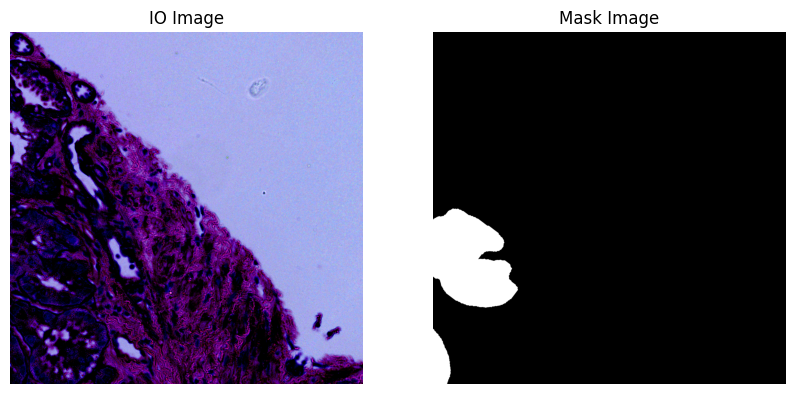

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Iterate through the batch of images and masks
for i in range(images.shape[0]):
    io_image = images[i].permute(1, 2, 0).numpy()  # Shift the channel to the end
    mask_image = masks[i].squeeze().numpy()  # Remove the channel dimension for mask

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the images
    axes[0].imshow(io_image)
    axes[0].set_title('IO Image')
    axes[0].axis('off')

    axes[1].imshow(mask_image, cmap='gray')
    axes[1].set_title('Mask Image')
    axes[1].axis('off')

    plt.show()



In [21]:
#!pip install segmentation-models-pytorch

In [22]:
#!pip install albumentations

In [23]:
import segmentation_models_pytorch as smp
import torch
from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim



# Define the model
model = smp.Unet(encoder_name="timm-mobilenetv3_small_100", encoder_weights="imagenet", in_channels=3, classes=1)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks,weights in tqdm(dataloader):
        print("done loading batch")
        images = images.to(device)
        masks = masks.to(device)
        weights = weights.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        print("doing forward pass")
        outputs = model(images)

        loss = criterion(outputs, masks.float()) 
        loss = (loss * (edge_weight ** weights).type_as(loss)).mean()

        # Mask for positives and unlabeled
        positive_mask = (masks == 1).float()
        unlabeled_mask = (masks == 0).float()

        # Weighted loss
        positive_loss = 1.0  * (loss * positive_mask).mean()
        unlabeled_loss = .1* (loss * unlabeled_mask).mean()




        loss_total  =  positive_loss + unlabeled_loss

        
        print("losses:\t",loss_total,positive_mask.sum(),positive_loss,unlabeled_loss)
        # Backward pass and optimize
        loss_total.backward()
        optimizer.step()

        running_loss += loss_total.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}")

print("Training complete")

cpu


0it [00:00, ?it/s]

dict_keys(['1_323']) [<Tile 1>, <Tile 2>, <Tile 3>, <Tile 4>, <Tile 5>, <Tile 6>, <Tile 7>, <Tile 8>, <Tile 9>, <Tile 10>, <Tile 11>, <Tile 12>, <Tile 13>, <Tile 14>, <Tile 15>, <Tile 16>, <Tile 17>, <Tile 18>, <Tile 19>, <Tile 20>, <Tile 21>, <Tile 22>, <Tile 23>, <Tile 24>, <Tile 25>, <Tile 26>, <Tile 27>, <Tile 28>, <Tile 29>, <Tile 30>, <Tile 31>, <Tile 32>, <Tile 33>, <Tile 34>, <Tile 35>, <Tile 36>, <Tile 37>, <Tile 38>, <Tile 39>, <Tile 40>, <Tile 41>, <Tile 42>, <Tile 43>, <Tile 44>, <Tile 45>, <Tile 46>, <Tile 47>, <Tile 48>, <Tile 49>, <Tile 50>, <Tile 51>, <Tile 52>, <Tile 53>, <Tile 54>, <Tile 55>, <Tile 56>, <Tile 57>, <Tile 58>, <Tile 59>, <Tile 60>, <Tile 61>, <Tile 62>, <Tile 63>, <Tile 64>, <Tile 65>, <Tile 66>, <Tile 67>, <Tile 68>, <Tile 69>, <Tile 70>, <Tile 71>, <Tile 72>, <Tile 73>, <Tile 74>, <Tile 75>, <Tile 76>, <Tile 77>, <Tile 78>, <Tile 79>, <Tile 80>, <Tile 81>, <Tile 82>, <Tile 83>, <Tile 84>, <Tile 85>, <Tile 86>, <Tile 87>, <Tile 88>, <Tile 89>, <Tile 90

1it [00:17, 17.21s/it]

done loading batch
doing forward pass
losses:	 tensor(0.2141, grad_fn=<AddBackward0>) tensor(226772.) tensor(0.0779, grad_fn=<MulBackward0>) tensor(0.1362, grad_fn=<MulBackward0>)


2it [00:23, 10.93s/it]

done loading batch
doing forward pass
losses:	 tensor(0.7307, grad_fn=<AddBackward0>) tensor(1905412.) tensor(0.6523, grad_fn=<MulBackward0>) tensor(0.0784, grad_fn=<MulBackward0>)


3it [00:33, 10.28s/it]

done loading batch
doing forward pass
losses:	 tensor(0.2601, grad_fn=<AddBackward0>) tensor(501233.) tensor(0.1498, grad_fn=<MulBackward0>) tensor(0.1104, grad_fn=<MulBackward0>)


4it [00:40,  8.91s/it]

done loading batch
doing forward pass
losses:	 tensor(0.2162, grad_fn=<AddBackward0>) tensor(376200.) tensor(0.1073, grad_fn=<MulBackward0>) tensor(0.1089, grad_fn=<MulBackward0>)


5it [00:50,  9.33s/it]

done loading batch
doing forward pass
losses:	 tensor(0.4479, grad_fn=<AddBackward0>) tensor(1170542.) tensor(0.3560, grad_fn=<MulBackward0>) tensor(0.0920, grad_fn=<MulBackward0>)


6it [00:57,  8.53s/it]

done loading batch
doing forward pass
losses:	 tensor(0.2021, grad_fn=<AddBackward0>) tensor(376684.) tensor(0.1004, grad_fn=<MulBackward0>) tensor(0.1017, grad_fn=<MulBackward0>)


7it [01:03,  7.89s/it]

done loading batch
doing forward pass
losses:	 tensor(0.1225, grad_fn=<AddBackward0>) tensor(68013.) tensor(0.0173, grad_fn=<MulBackward0>) tensor(0.1052, grad_fn=<MulBackward0>)


8it [01:17,  9.68s/it]

done loading batch
doing forward pass
losses:	 tensor(0.5929, grad_fn=<AddBackward0>) tensor(1777109.) tensor(0.5219, grad_fn=<MulBackward0>) tensor(0.0710, grad_fn=<MulBackward0>)


9it [01:24,  8.91s/it]

done loading batch
doing forward pass
losses:	 tensor(0.4665, grad_fn=<AddBackward0>) tensor(1260705.) tensor(0.3784, grad_fn=<MulBackward0>) tensor(0.0881, grad_fn=<MulBackward0>)


10it [01:31,  8.20s/it]

done loading batch
doing forward pass
losses:	 tensor(0.4647, grad_fn=<AddBackward0>) tensor(1569859.) tensor(0.3981, grad_fn=<MulBackward0>) tensor(0.0666, grad_fn=<MulBackward0>)


11it [01:38,  7.97s/it]

done loading batch
doing forward pass
losses:	 tensor(0.1315, grad_fn=<AddBackward0>) tensor(195114.) tensor(0.0431, grad_fn=<MulBackward0>) tensor(0.0884, grad_fn=<MulBackward0>)


12it [01:47,  8.42s/it]

done loading batch
doing forward pass


12it [01:50,  9.18s/it]


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


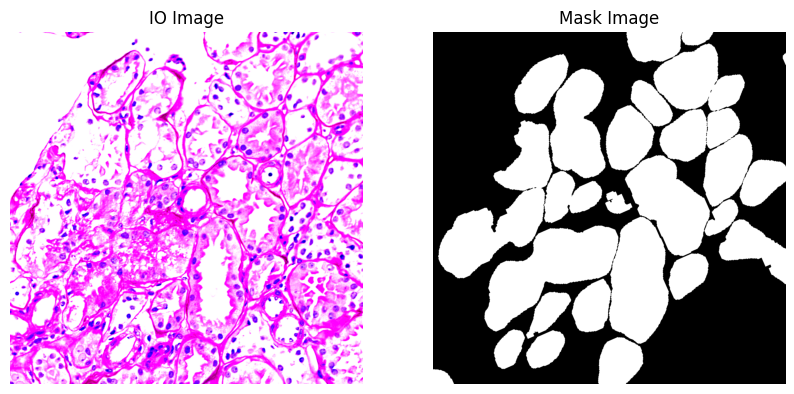

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Iterate through the batch of images and masks
for i in range(images.shape[0]):
    io_image = images[i].permute(1, 2, 0).numpy()  # Shift the channel to the end
    mask_image = masks[i].squeeze().numpy()  # Remove the channel dimension for mask

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the images
    axes[0].imshow(io_image)
    axes[0].set_title('IO Image')
    axes[0].axis('off')

    axes[1].imshow(mask_image, cmap='gray')
    axes[1].set_title('Mask Image')
    axes[1].axis('off')

    plt.show()



In [25]:
dataset.cache.keys()

dict_keys(['1_323', '1_324', '1_397', '1_398', '1_470', '1_471', '1_472', '1_542', '1_543', '1_544', '1_545', '1_615', '1_616'])

In [26]:
image_id = 1
tile_id = 323
infertile = [t for t in tiles if t.image_id ==image_id and tile_id == t.id][0]
print(infertile)

<Tile 323>


cache hit
(2048, 2048, 3)


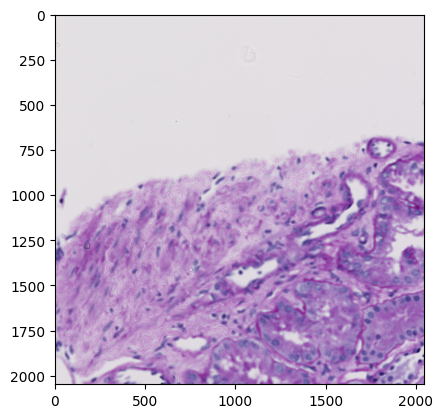

In [27]:
cache_key = f"{image_id}_{tile_id}"

if cache_key in dataset.cache:
    print("cache hit")
    io_image, mask_image,weight = dataset.cache[cache_key]
else:
    tpoly = shapely.wkb.loads(infertile.geom.data)

    # Get the bounds of the polygon
    minx, miny, maxx, maxy = tpoly.bounds

    # Compute the width and height
    width = int(maxx - minx)
    height = int(maxy - miny)

    #--- image work
    image = session.query(Image).filter_by(id=image_id).first()

    image_path = image.path
    slide = openslide.OpenSlide("../" + image_path)

    # Extract the region defined by the tile
    region = slide.read_region((int(minx), int(miny)), 0, (width, height))
    io_image = np.array(region.convert("RGB"))

print(io_image.shape)
plt.imshow(io_image)

In [28]:
io_orig = io_image.copy()

In [29]:
io_image= io_orig.copy()
# Normalize the io_image
model.eval()
with torch.no_grad():
    io_image = io_image / 255.0  # Normalize to range [0, 1]
    io_image = (io_image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])  # Apply mean and std normalization
    io_image = np.pad(io_image, ((32, 32), (32, 32), (0, 0)), mode='reflect')

    io_image = torch.tensor(io_image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)  # Convert to tensor and move to device
    
    print(io_image.shape)
    # Pass through the model
    outputs = model(io_image)
    
    # Remove the padding
    outputs = outputs[:, :, 32:-32, 32:-32]
    print(outputs.shape)

torch.Size([1, 3, 2112, 2112])
torch.Size([1, 1, 2048, 2048])


In [30]:
outputs = outputs.squeeze().detach().cpu().numpy()

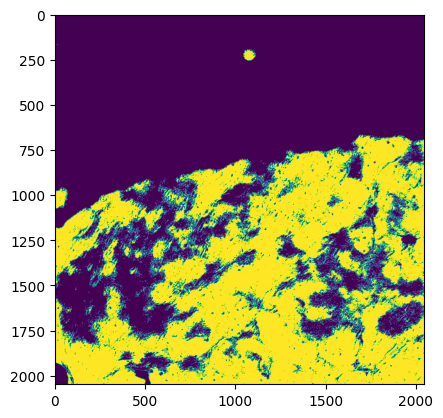

In [31]:
plt.imshow(outputs>0)

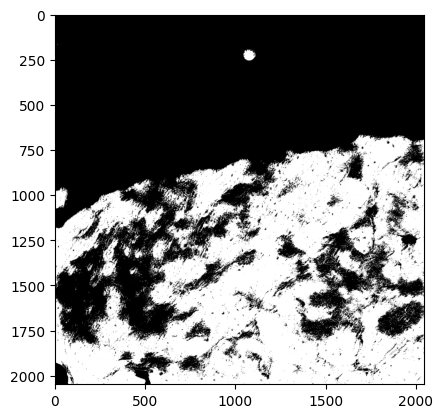

In [35]:
# import cv2

# # Normalize outputs to range [0, 255]
# outputs_normalized = (outputs - outputs.min()) / (outputs.max() - outputs.min())
# outputs_uint8 = (outputs_normalized * 255).astype(np.uint8)
# # Compute Otsu's threshold value
# otsu_threshold_value, _ = cv2.threshold(outputs_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# positive_mask = outputs_uint8 > otsu_threshold_value
# plt.imshow(positive_mask, cmap='gray')
# plt.show()


positive_mask = outputs> 0
plt.imshow(positive_mask, cmap='gray')
plt.show()


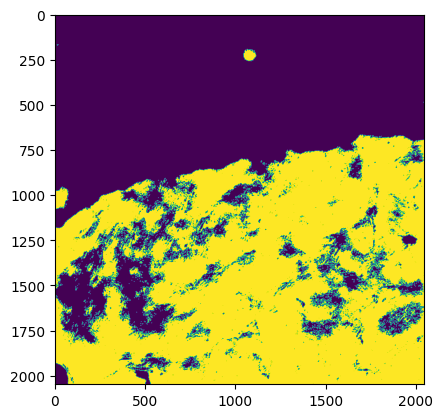

In [36]:

# Merge groups of pixels which are at most 2 away
kernel = np.ones((2, 2), np.uint8)
positive_mask = cv2.dilate(positive_mask.astype(np.uint8), kernel, iterations=2)>0
plt.imshow(positive_mask>0)
plt.show()


In [37]:

# Find contours in the positive mask
contours, _ = cv2.findContours(positive_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
len(contours)


853

In [40]:

from shapely.geometry import Polygon, mapping

# Convert contours to shapely polygons
polygons = [Polygon(contour.squeeze()) for contour in contours if len(contour) > 2]

# Filter out small polygons
polygons = [polygon for polygon in polygons if polygon.area >= 100]


# Convert shapely polygons to GeoJSON
geojson = [mapping(polygon) for polygon in polygons]

# Print the GeoJSON
for feature in geojson:
    print(feature)
print(len(polygons))



{'type': 'Polygon', 'coordinates': (((518.0, 1924.0), (518.0, 1925.0), (517.0, 1926.0), (515.0, 1926.0), (515.0, 1927.0), (514.0, 1928.0), (512.0, 1928.0), (511.0, 1929.0), (509.0, 1929.0), (509.0, 1932.0), (508.0, 1933.0), (507.0, 1933.0), (507.0, 1935.0), (506.0, 1936.0), (505.0, 1936.0), (505.0, 1937.0), (504.0, 1938.0), (502.0, 1938.0), (502.0, 1939.0), (501.0, 1940.0), (499.0, 1940.0), (498.0, 1941.0), (498.0, 1942.0), (497.0, 1943.0), (492.0, 1943.0), (491.0, 1944.0), (489.0, 1944.0), (489.0, 1946.0), (488.0, 1947.0), (486.0, 1947.0), (486.0, 1949.0), (487.0, 1950.0), (487.0, 1952.0), (488.0, 1953.0), (488.0, 1955.0), (490.0, 1955.0), (491.0, 1954.0), (492.0, 1954.0), (493.0, 1953.0), (495.0, 1953.0), (496.0, 1952.0), (502.0, 1952.0), (503.0, 1953.0), (502.0, 1954.0), (502.0, 1956.0), (503.0, 1956.0), (504.0, 1957.0), (504.0, 1958.0), (507.0, 1958.0), (508.0, 1957.0), (509.0, 1957.0), (510.0, 1956.0), (511.0, 1956.0), (512.0, 1955.0), (513.0, 1955.0), (514.0, 1956.0), (514.0, 195

In [162]:
# from matplotlib.patches import Polygon as MplPolygon

# import matplotlib.pyplot as plt

# #
# # Calculate the number of rows and columns
# num_polygons = len(polygons)
# num_columns = 5
# num_rows = (num_polygons + num_columns - 1) // num_columns

# # Create a figure for the contact sheet
# fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 3, num_rows * 3))

# # Flatten the axes array for easy iteration
# axes = axes.flatten()

# # Plot each polygon in the contact sheet
# for i, polygon in enumerate(polygons):
#     ax = axes[i]
#     ax.set_xlim(0, tile_width)
#     ax.set_ylim(0, tile_height)
#     ax.set_aspect('equal')
#     ax.axis('off')

#     # Adjust the coordinates of the polygon to match the image coordinates
#     coords = [(x - minx, tile_height - (y - miny)) for x, y in polygon.exterior.coords]

#     # Create a matplotlib polygon patch
#     poly_patch = MplPolygon(coords, closed=True, edgecolor='r', facecolor='blue', alpha=0.5)
#     ax.add_patch(poly_patch)

#     # Add a bounding box around the subplot
#     rect = plt.Rectangle((0, 0), tile_width, tile_height, linewidth=1, edgecolor='black', facecolor='none')
#     ax.add_patch(rect)

# # Hide any remaining empty subplots
# for j in range(i + 1, len(axes)):
#     axes[j].axis('off')

# plt.tight_layout()
# plt.show()

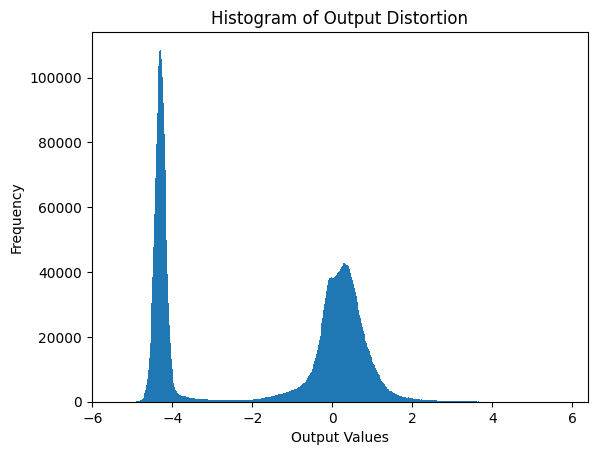

In [42]:
plt.hist(outputs.flatten(), bins=512)
plt.title('Histogram of Output Distortion')
plt.xlabel('Output Values')
plt.ylabel('Frequency')
plt.show()

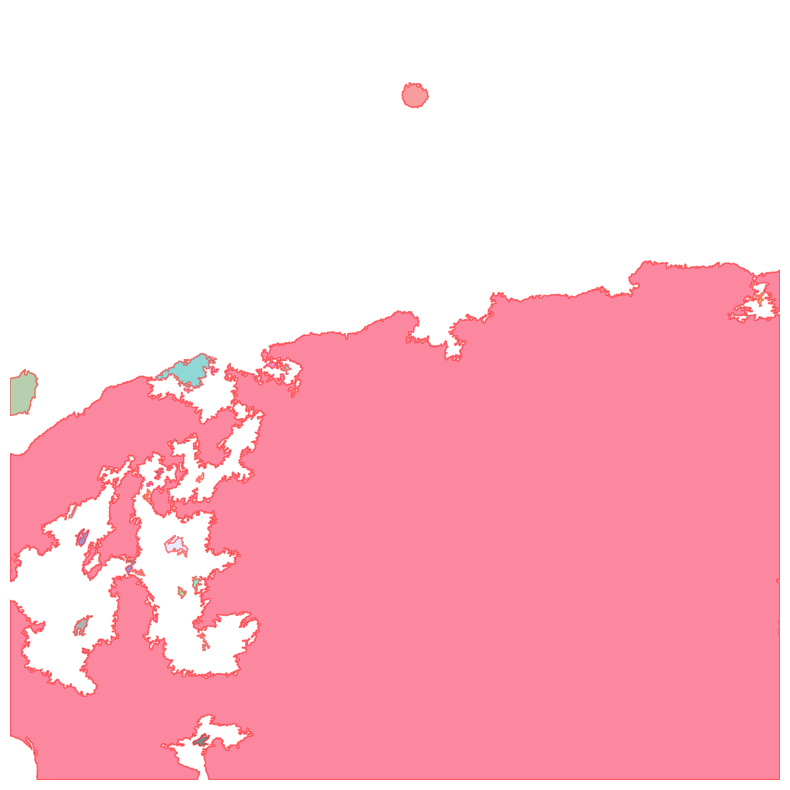

In [44]:
from matplotlib.patches import Polygon as MplPolygon
import random

num_polygons = len(polygons)

import matplotlib.pyplot as plt
# Generate a list of random colors for the polygons
colors = ['#%06X' % random.randint(0, 0xFFFFFF) for _ in range(num_polygons)]

# Create a single panel figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(0, tile_width)
ax.set_ylim(0, tile_height)
ax.set_aspect('equal')
ax.axis('off')

# Plot each polygon with a different color
for i, polygon in enumerate(polygons):
    coords = [(x - minx, tile_height - (y - miny)) for x, y in polygon.exterior.coords]
    poly_patch = MplPolygon(coords, closed=True, edgecolor='r', facecolor=colors[i], alpha=0.5)
    ax.add_patch(poly_patch)

plt.show()

In [47]:
from quickannotator.db import Annotation, build_annotation_table_name

gtpred = 'pred'  # or 'pred' based on your requirement
table_name = build_annotation_table_name(image_id, class_id, gtpred == 'gt')
print(table_name)
# Define the table dynamically
table = Table(table_name, db.metadata, autoload_with=engine)

# Iterate through the list of polygons
for polygon in polygons:
    # Translate the polygon by the tile's minx and miny
    translated_polygon = shapely.affinity.translate(polygon, xoff=minx, yoff=miny)
    
    # Calculate the area and centroid of the polygon
    area = translated_polygon.area
    centroid = translated_polygon.centroid
    
    
    # Create a new annotation dictionary
    new_annotation = {
        'image_id': image_id,
        'annotation_class_id': class_id,
        'polygon': translated_polygon.wkt,
        'area': area,
        'isgt': False,
        'centroid': centroid.wkt  # Use the centroid variable directly
    }
    
    # Insert the new annotation into the table
    insert_stmt = table.insert().values(new_annotation)
    session.execute(insert_stmt)

# Commit the session to save the annotations to the database
session.commit()





1_2_pred_annotation
